In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [3]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

In [4]:
# ============================================
# 2. Obter POIs de interesse
# ============================================
pois_info = [
    {"name": "Morro do Careca", "color": "blue", "coordinates": (-5.883684255366649, -35.16444783802863)},
    {"name": "Forte dos Reis Magos", "color": "green", "coordinates": (-5.756266898447098, -35.19497968971633)},
    {"name": "Praia dos Artistas", "color": "purple", "coordinates": (-5.781604, -35.192590)},
    {"name": "Shopping Artesanato Vilarte", "color": "pink", "coordinates": (-5.873288439766393, -35.17958640726536)},
    {"name": "Centro de Turismo", "color": "orange", "coordinates": (-5.779237413367311, -35.196641022055665)},
    {"name": "Museu Câmara Cascudo", "color": "cyan", "coordinates": (-5.803170160249714, -35.20119414420729)},
    {"name": "Parque da Cidade", "color": "yellow", "coordinates": (-5.850235280916188, -35.226226951926)},
    {"name": "Farol de Mãe Luiza", "color": "red", "coordinates": (-5.795123635137049, -35.185171185948214)},
]

In [5]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
for poi in pois_info:
    lat, lon = poi["coordinates"]
    node = ox.distance.nearest_nodes(G_undirected, X=[lon], Y=[lat])[0]
    poi["node"] = node

# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
pois_nodes = [poi["node"] for poi in pois_info]
G_interest = nx.Graph()
for i in range(len(pois_nodes)):
    for j in range(i + 1, len(pois_nodes)):
        route = nx.shortest_path(G_undirected, pois_nodes[i], pois_nodes[j], weight="length")
        route_length = 0
        for k in range(len(route) - 1):
            route_length += G_undirected[route[k]][route[k + 1]][0]["length"]
        G_interest.add_edge(pois_nodes[i], pois_nodes[j], weight=route_length)

# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d["weight"] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 24047.155743215968 metros


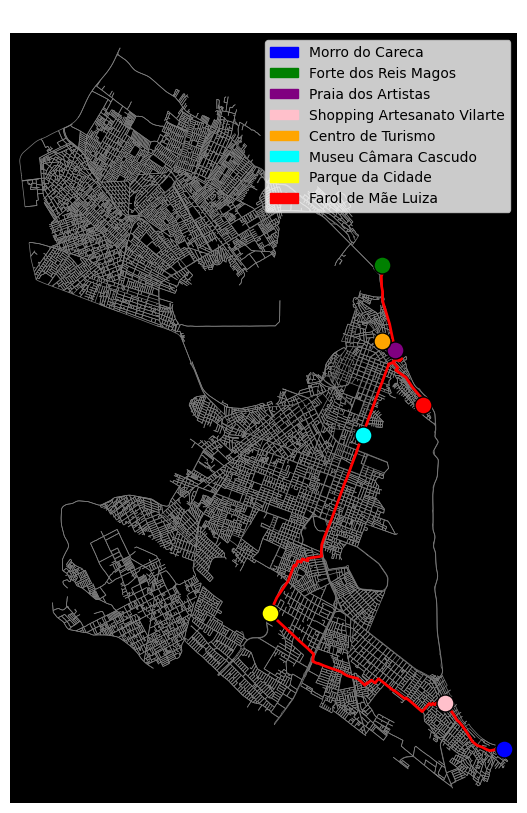

In [6]:
# Supondo que você já tenha as variáveis:
# G_undirected: grafo MultiGraph não-direcionado
# pois_nodes: lista de nós próximos aos hospitais
# mst_edges: lista de arestas do MST
# latitudes, longitudes: listas com lat/long dos hospitais

# Caso não tenha sido definido, você pode calcular um bbox se quiser
# bbox_padding = 0.02
# north = max(latitudes) + bbox_padding
# south = min(latitudes) - bbox_padding
# east = max(longitudes) + bbox_padding
# west = min(longitudes) - bbox_padding

# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected,
    show=False,
    close=False,
    edge_color="gray",
    edge_linewidth=0.5,
    node_size=0,
    bgcolor="black",
    figsize=(10, 10),
)

# Destacar as rotas do MST em vermelho
for u, v, data in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight="length")
    x = [G_undirected.nodes[n]["x"] for n in route]
    y = [G_undirected.nodes[n]["y"] for n in route]
    ax.plot(x, y, color="red", linewidth=2, zorder=4)

# Adicionar os POIs ao gráfico e criar a legenda
legend_handles = []
for poi in pois_info:
    node = poi["node"]
    poi_x = G_undirected.nodes[node]["x"]
    poi_y = G_undirected.nodes[node]["y"]
    ax.scatter(poi_x, poi_y, c=poi["color"], s=150, zorder=5, edgecolor="black", label=poi["name"])
    legend_handles.append(mpatches.Patch(color=poi["color"], label=poi["name"]))

# Adicionar a legenda
ax.legend(handles=legend_handles, loc="best", fontsize=10)

plt.title("MST entre Pontos Turísticos de Natal", fontsize=14, color="white")
plt.show()